In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import sys
import datetime
import matplotlib.pyplot as plt
import pyfolio as pf

sys.path.insert(0, '/mnt/afml/ml_finance/mlfinlab')
from mlfinlab.data_structures import imbalance_data_structures as imbar, standard_data_structures as bar
import mlfinlab as ml

sys.path.insert(0, '/mnt/afml/ml_finance/finance_ml')
from finance_ml import sampling, features

/mnt/afml/venv/lib/python3.5/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
def load_parq(fname):
    table = pq.read_table(fname)
    df = table.to_pandas()
    df = df.set_index('TIMESTAMP')
    ''' 중복된 index 제거, volume은 더해준다 '''
    df = df.sort_values(by='TIMESTAMP')  # 중복 데이터 무시
    df_v = df.groupby(df.index).sum()
    df = df.loc[~df.index.duplicated(keep='first')]
    df['V'] = df_v['V']
    df['DV'] = df_v['DV']
    return df

In [3]:
fname = 'dataset/TRADE_A233740_2018.parq'
df = load_parq(fname)

## Get dollar bar

In [4]:
fname = 'dataset/TRADE_A233740_2018.csv'
bar_fname = 'dataset/DBAR_A233740_2018.csv'
if not os.path.exists(fname):
    df_csv = df.reset_index()[['TIMESTAMP', 'PRICE', 'V']]
    df_csv.columns = ['date_time', 'price', 'volume']
    df_csv['price'] = df_csv['price'].astype('float')
    df_csv.to_csv(fname, index=False)
    
if os.path.exists(bar_fname):
    dbar = pd.read_csv(bar_fname, index_col='date_time')
    dbar.index = pd.to_datetime(dbar.index)
else:
    dbar = bar.get_dollar_bars(fname, threshold=1e8)
    dbar.index = pd.to_datetime(dbar.index)
    dbar.to_csv(bar_fname)

In [5]:
print(df.shape)
print(dbar.shape)

(7647271, 5)
(518545, 5)


In [6]:
def plot_bars(df, df_bar, desc='bar'):
    plt.figure(figsize = (18, 8))
    plt.title('Bars over the prices')
    plt.plot(df.index, df['PRICE'], label = 'Raw prices', color = 'blue')
    plt.plot(df_bar.index, df_bar['close'], ls = '', markersize = 5, marker = 'o', color = 'red', label = desc)
    plt.legend()
    plt.show()

In [7]:
def plot_co_events(d0, df, t_barrier_events, num_co_events, avg_uniq): 
    df0 = df.loc[d0]
    t_barrier_events0 = t_barrier_events.loc[d0]
    num_co_events0 = num_co_events.loc[d0]
    avg_uniq0 = avg_uniq.loc[d0]
    
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)

    plt.title('Triple barriers over the prices')
    plt.plot(df0.index.values, df0.close.values, label='raw_prices', ls='--', color='black')

    # Draw barrier region 
    for i in t_barrier_events0.itertuples(): 
        try: 
            t0, t1, trgt = i.Index, i.t1, i.trgt
            t1 = min(t1, pd.Timestamp("{} 15:30".format(d0)))

            x0 = mdates.date2num(t0)
            x1 = mdates.date2num(t1)
            w = x1 - x0 

            y0 = df0.loc[t0].close * (1 - trgt)
            y1 = df0.loc[t0].close * (1 + trgt)
            h = y1 - y0

            rect = Rectangle((x0, y0), w, h, color='black', alpha=0.05)
            ax.add_patch(rect)

            df1 = df0.loc[[t0, t1]].dropna()

            plt.plot(df1.index.values, df1.close.values, label='triple barrier', ls='--', color='red')
            if df1.shape[0] >= 2:
                plt.scatter(df1.index.values[1], df1.close.values[1], marker='o', linewidths=5, color='red')
                
        except Exception as e:
            print(e)
    plt.show()
    
    # Draw num of co-events
    num_co_events0.plot(kind='bar', figsize=(30,10), label='DV')
    plt.show()
    
    # Draw average uniqueness
    avg_uniq0.plot(kind='bar', figsize=(30,10), label='AvgUniqueness')
    plt.show()

In [8]:
df_sub = df[df.index>datetime.datetime(2018,5,23,9,0)]
df_sub = df_sub[df_sub.index<datetime.datetime(2018,5,24,9,0)]
dbar_sub = dbar[dbar.index>datetime.datetime(2018,5,23,9,0)]
dbar_sub = dbar_sub[dbar_sub.index<datetime.datetime(2018,5,24,9,0)]

## Apply triple barrier

In [9]:
diff = np.log(dbar['close']).diff()

In [10]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=dbar['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
daily_vol_mean = daily_vol.rolling(10000).mean()
cusum_events = ml.filters.cusum_filter(dbar['close'], daily_vol_mean=daily_vol_mean)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=dbar['close'], num_days=1)

Timestamp('2018-01-03 09:00:21.481000')


## Primary - Build Label

In [112]:
pt_sl = [1, 2]
min_ret = 0.01
triple_barrier_events = ml.labeling.get_events(close=dbar['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)

2019-06-17 10:40:09.913387 100.0% apply_pt_sl_on_t1 done after 0.02 minutes. Remaining 0.0 minutes.


In [113]:
labels_p = ml.labeling.get_bins(triple_barrier_events, dbar['close'])

In [114]:
labels_p.bin.value_counts()

-1    334
 1    283
 0    136
Name: bin, dtype: int64

## Features

In [14]:
raw_data = dbar.copy()

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Remove look ahead bias
raw_data = raw_data.shift(1)

In [115]:
# Get features at event dates
X = raw_data

# Drop unwanted columns
try:
    X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)
except Exception as e:
    print(e)

X.dropna(inplace=True)
y = labels_p['bin']

"['open' 'high' 'low' 'close' 'volume'] not found in axis"


In [116]:
com_idx = y.index.join(X.index).join(labels_p.index)
X = X.loc[com_idx]
y = y.loc[com_idx]

## Primary - Balance classes

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [117]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

## Primary - Fit a model

In [118]:
n_estimator = 10
depth = 2
c_random_state = 42

# Refit a new model with best params, so we can see feature importance
rf1 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf1.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Meta Labeling

In [119]:
X = raw_data
X.dropna(inplace=True)
try:
    X.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)
except Exception as e:
    print(e)

"['open' 'high' 'low' 'close' 'volume'] not found in axis"


In [120]:
total_predict = rf1.predict(X)

In [121]:
dbar2 = dbar.loc[X.index]

In [122]:
dbar2['side'] = total_predict

In [123]:
pt_sl = [1, 2]
min_ret = 0.005
triple_barrier_events = ml.labeling.get_events(close=dbar2['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=dbar2['side'])

2019-06-17 10:40:33.658676 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes.


In [124]:
triple_barrier_events.head()

,side,t1,trgt
2018-01-09 09:01:09.291,-1.0,2018-01-09 09:02:53.717,0.005417
2018-01-09 09:01:32.046,-1.0,2018-01-09 09:02:38.938,0.005706
2018-01-09 09:02:03.804,-1.0,2018-01-09 09:02:53.717,0.005768
2018-01-09 09:02:29.405,-1.0,2018-01-09 09:02:55.275,0.005546
2018-01-09 09:02:46.421,-1.0,2018-01-09 09:03:00.761,0.005789


In [125]:
labels_m = ml.labeling.get_bins(triple_barrier_events, dbar2['close'])
labels_m.side.value_counts()

-1.0    2392
 1.0    1225
Name: side, dtype: int64

In [126]:
labels_m.bin.value_counts()

1    2261
0    1356
Name: bin, dtype: int64

In [127]:
y = labels_m['bin']

## Meta - Prepare training data

In [128]:
com_idx = y.index.join(X.index).join(labels_m.index)
X = X.loc[com_idx]
y = y.loc[com_idx]
labels_m = labels_m.loc[com_idx]

In [129]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

## Meta - Balance classes

In [130]:
# Split data into training, validation and test sets
X_training_validation = X['2018-01-01':'2018-10-31']
y_training_validation = y['2018-01-01':'2018-10-31']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [131]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    1577
0     927
Name: bin, dtype: int64

In [132]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    927
0    927
Name: bin, dtype: int64

## Meta - Fit a Model

In [133]:
# Refit a new model with best params, so we can see feature importance
rf2 = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Bet Sizing

In [134]:
from finance_ml.labeling.sizes import get_signal

In [135]:
y_prob = rf2.predict_proba(X_train)

In [136]:
y_prob

array([[0.37042055, 0.62957945],
       [0.33056842, 0.66943158],
       [0.37042055, 0.62957945],
       ...,
       [0.37042055, 0.62957945],
       [0.37042055, 0.62957945],
       [0.39005255, 0.60994745]])

In [137]:
y_df = pd.Series(y_prob[:,1], index=X_train.index)

In [138]:
triple_barrier_events.head()

,side,t1,trgt
2018-01-09 09:01:09.291,-1.0,2018-01-09 09:02:53.717,0.005417
2018-01-09 09:01:32.046,-1.0,2018-01-09 09:02:38.938,0.005706
2018-01-09 09:02:03.804,-1.0,2018-01-09 09:02:53.717,0.005768
2018-01-09 09:02:29.405,-1.0,2018-01-09 09:02:55.275,0.005546
2018-01-09 09:02:46.421,-1.0,2018-01-09 09:03:00.761,0.005789


In [139]:
bet_size = get_signal(y_df, triple_barrier_events)

In [140]:
def plot_bs(df, bs, desc='bet_size'):
    fig, ax1 = plt.subplots(figsize=(18,10))
    plt.title('Bet size over the prices')
    ax1.plot(df.index, df['close'], label = 'Raw prices', color = 'blue')
    
    ax2 = ax1.twinx()
    ax2.plot(bs.index, bs, ls = '', markersize = 10, marker='o', color = 'red', label = desc)
    fig.figsizes = (18,10)
    plt.legend()
    plt.show()

In [141]:
plot_date = '2018-02-13'
triple_barrier_events.loc[plot_date]

,side,t1,trgt
2018-02-13 09:01:11.396,1.0,2018-02-13 09:29:22.830,0.006891
2018-02-13 10:05:15.702,-1.0,2018-02-13 10:13:02.320,0.005395


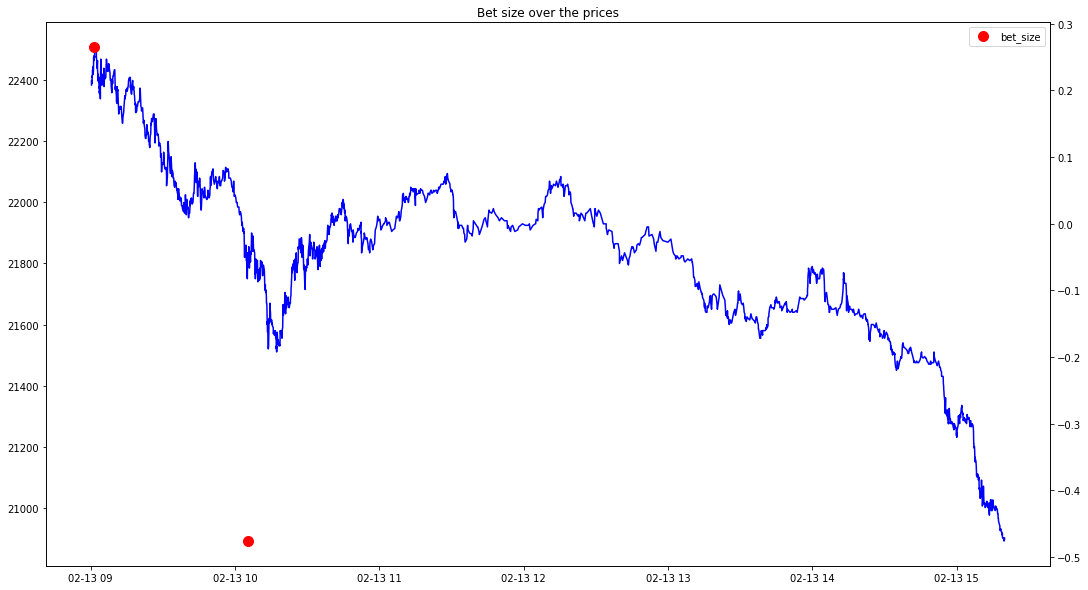

In [142]:
plot_date = '2018-02-13'
plot_bs(dbar.loc[plot_date], bet_size.loc[plot_date])

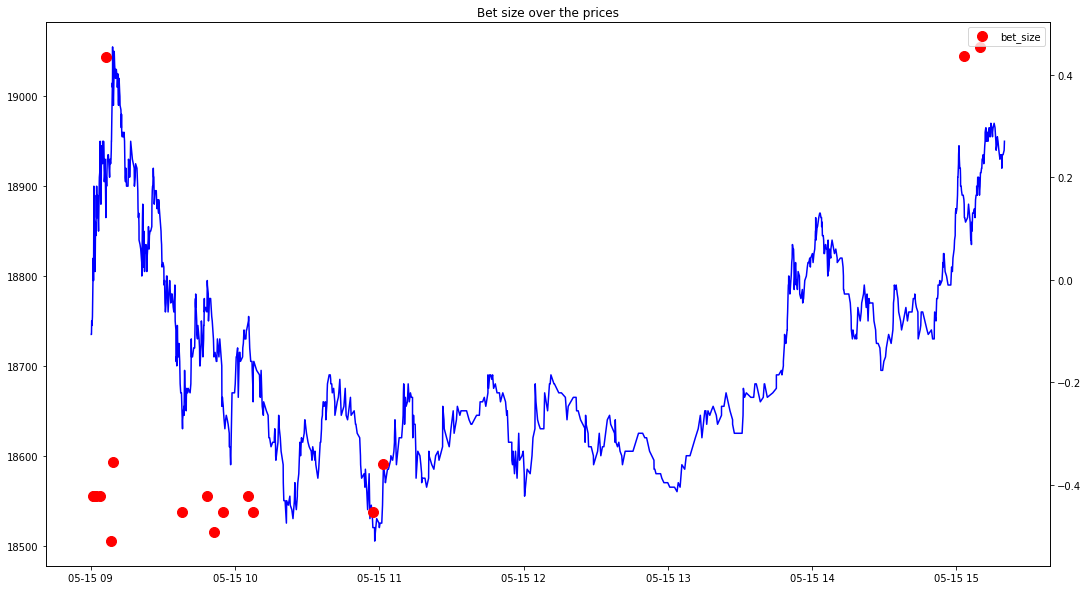

In [143]:
plot_date = '2018-05-15'
plot_bs(dbar.loc[plot_date], bet_size.loc[plot_date])

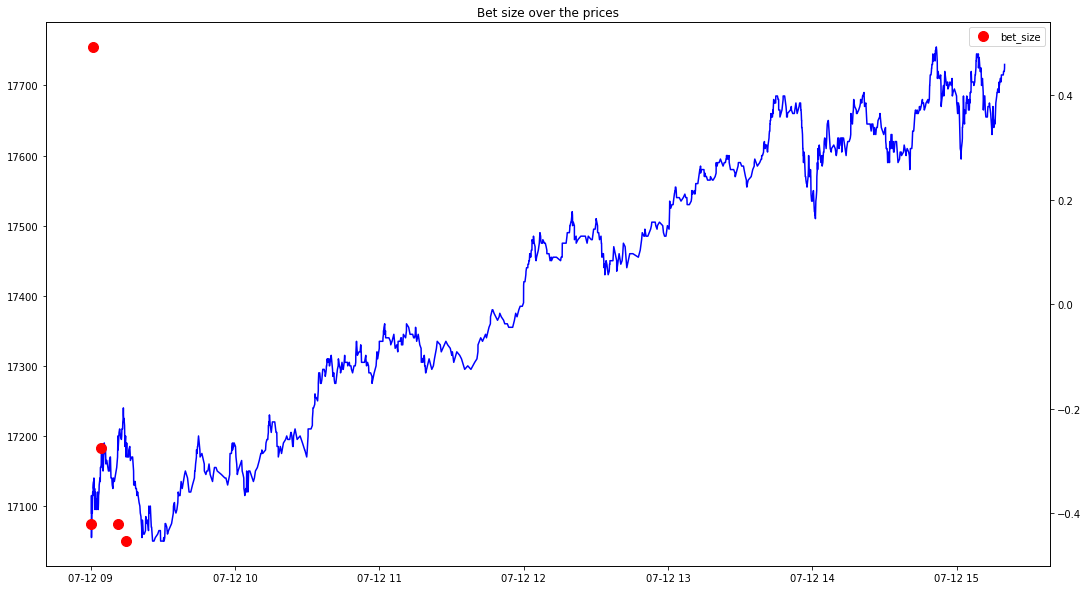

In [144]:
plot_date = '2018-07-12'
plot_bs(dbar.loc[plot_date], bet_size.loc[plot_date])

In [46]:
def betSize(w,x): 
    return x*(w+x**2)**-.5
#——————————————————————————————————————— 
def getTPos(w,f,mP,maxPos): 
    return int(betSize(w,f-mP)*maxPos) 
#——————————————————————————————————————— 
def invPrice(f,w,m): 
    return f-m*(w/(1-m**2))**.5
#——————————————————————————————————————— 
def limitPrice(tPos,pos,f,w,maxPos): 
    sgn=(1 if tPos>=pos else -1) 
    lP=0 
    for j in range(abs(pos+sgn),abs(tPos+1)): 
        lP+=invPrice(f,w,j/float(maxPos))
    lP/=tPos-pos 
    return lP
#——————————————————————————————————————— 
def getW(x,m): 
    # 0<alpha<1 
    return x**2*(m**-2-1)
#——————————————————————————————————————— 

pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95} 
# calibrate w 
w=getW(wParams['divergence'],wParams['m']) 
print(w)
# get tPos 
tPos=getTPos(w,f,mP,maxPos) 
print(tPos)
# limit price for order return
lP=limitPrice(tPos,pos,f,w,maxPos) 
print(lP)

10.803324099723
97
112.36573855883363
